In [2]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
from librosa.display import specshow
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("data/datamatrix.csv", sep=';', index_col=0).transpose().applymap(np.log1p)
data.describe()

,100.110350,102.010985,102.032212,102.535130,109.012080,110.017963,110.522609,111.019337,111.087585,111.521389,...,945.579366,945.605541,946.580795,946.601468,946.617601,947.609497,977.587261,977.606791,978.566742,978.594623
count,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,...,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000,5250.000000
mean,0.020704,0.009390,0.154996,0.014959,0.090451,0.127847,0.013149,0.137530,0.009558,0.009448,...,0.012574,0.069513,0.024659,0.020548,0.021185,0.009739,0.038193,0.007919,0.007633,0.018749
std,0.451992,0.304164,1.230900,0.382977,0.941876,1.116413,0.359912,1.158518,0.309763,0.306057,...,0.372808,0.888858,0.515680,0.471045,0.485450,0.315677,0.652006,0.287219,0.276583,0.452732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.420405,9.901936,10.961729,10.058823,10.598258,10.952770,9.920984,10.850055,10.580531,10.189606,...,11.969591,12.216003,11.349830,11.589145,11.622255,10.733981,11.924711,11.250651,10.408888,11.471489


In [45]:
X = data.to_numpy()
print(f"{X.shape = }")

X.shape = (5250, 824)


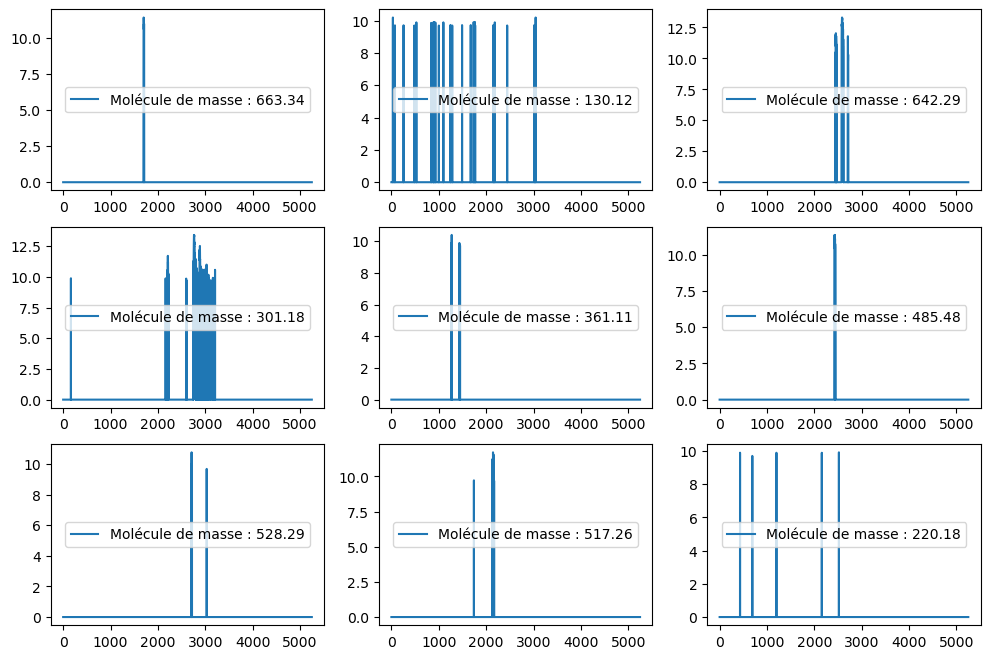

In [71]:
from random import randint
fig, ax = plt.subplots(3,3, figsize=(12,8))
for p in np.nditer(ax, flags=["refs_ok"]):
    ind = randint(0,len(X[0])-1)
    p[()].plot(X[:,ind], label=f"Molécule de masse : {data.columns[ind]:.2f}")
    p[()].legend(loc='center');

In [44]:
def son_optimise(mass_vector, abundance_matrix, sr=22050, duration=35, instrument="sinus"):
    try:
        assert(len(mass_vector) == len(abundance_matrix[0]))
    except:
        raise(Exception("Pas la bonne taille de données"))
    
    durationOfOneSample = duration*sr/len(abundance_matrix)
    
    time_vector = np.arange(0,duration*sr,1) / sr
    
    time_vector = time_vector.reshape((len(time_vector),1))
    mass_vector = np.transpose(mass_vector.reshape((len(mass_vector),1)))
    
    ### Update par rapport à son_v2.ipynb : Interpolation + Instruments ###
    amplitude_matrix = np.array(
        [(abundance_matrix[int(i/durationOfOneSample)+1] - abundance_matrix[int(i/durationOfOneSample)]) / durationOfOneSample * (i%durationOfOneSample) + abundance_matrix[int(i/durationOfOneSample)]  
         if int(i/durationOfOneSample) < len(abundance_matrix) - 1 
         else abundance_matrix[int(i/durationOfOneSample)]
         for i in range(duration*sr)]
    )
    
    if instrument == "sinus":
        sounds = np.multiply(amplitude_matrix, np.sin(np.pi * np.matmul(time_vector, mass_vector)))
    elif instrument == "violon":
        sounds = np.multiply(amplitude_matrix, instrument_violon(np.matmul(time_vector, mass_vector)))
    else:
        raise Exception("Invalid Instrument")
    ### Fin de l'update ###
    
    audio = np.mean(sounds,axis=1)
    
    return audio / np.max(audio)

In [85]:
def abundance_matrix(df, nb_pics=None, pic_selection="most_abundant"):
    # NB : spikes a un rôle analogue à spike_height dans son_v3
    spikes = df.to_numpy()
    
    # La définition de sorting_values change selon le mode de sélection
    
    if pic_selection == "most_abundant":
        sorting_values = df.sum().to_numpy()
    elif pic_selection == "highest_mass":
        sorting_values = df.columns
    elif pic_selection == "lowest_mass":
        sorting_values = (-1)*df.columns
    else:
        raise Exception("Error : acceptable values for pic_selection are \"most_abundant\", \"highest_mass\", \"lowest_mass\"")
    
    if nb_pics is None or nb_pics <= 0: 
        nb_pics = len(spikes)
    
    sorted_args = np.argsort(sorting_values)[::-1]
    am = spikes[:,sorted_args]
    am[:,nb_pics:] = 0
    
    return am

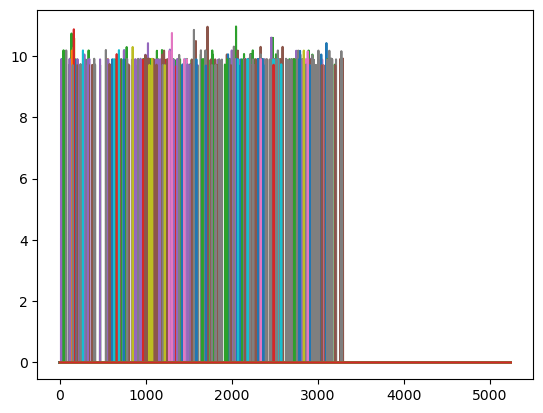

In [88]:
am = abundance_matrix(data, nb_pics=20, pic_selection="lowest_mass")
plt.plot(am);

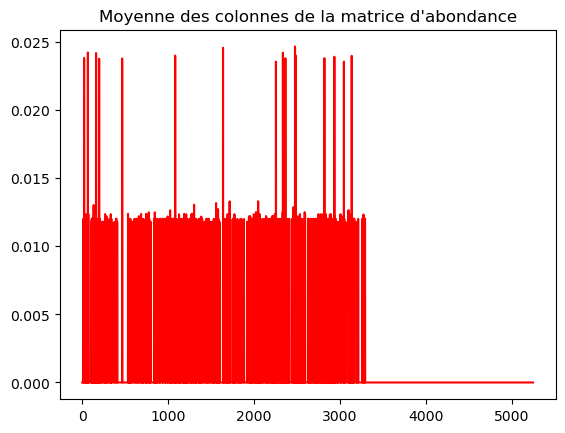

In [89]:
plt.plot(np.mean(am,axis=1),color='red');
plt.title("Moyenne des colonnes de la matrice d'abondance");

In [93]:
# Paramètres

sr = 11000 # sampling rate (fréquence d'échantillonage)
duration = 5
mass_vector = data.columns.to_numpy()
mass_vector = 1000 - mass_vector # On "inverse" les masses : les molécules plus légères (masse plus faible) seront plus aigües (fréquence plus forte)
abundance_matrix = am

In [95]:
%%time
audio = son_optimise(mass_vector, abundance_matrix, sr, duration)
display(ipd.Audio(audio, rate=sr))

CPU times: user 1.52 s, sys: 331 ms, total: 1.85 s
Wall time: 1.85 s


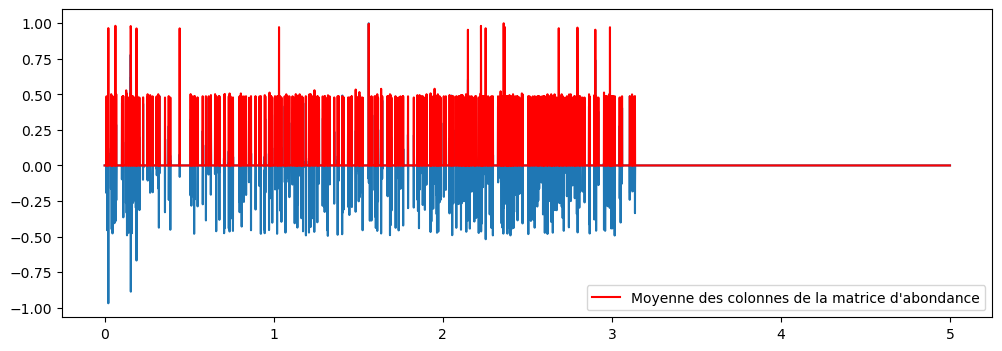

In [96]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,duration,1/sr),audio);
plt.plot(np.arange(0,duration,duration/len(am)),np.mean(am,axis=1)/np.max(np.mean(am,axis=1)),color='red',label="Moyenne des colonnes de la matrice d'abondance")
plt.legend();

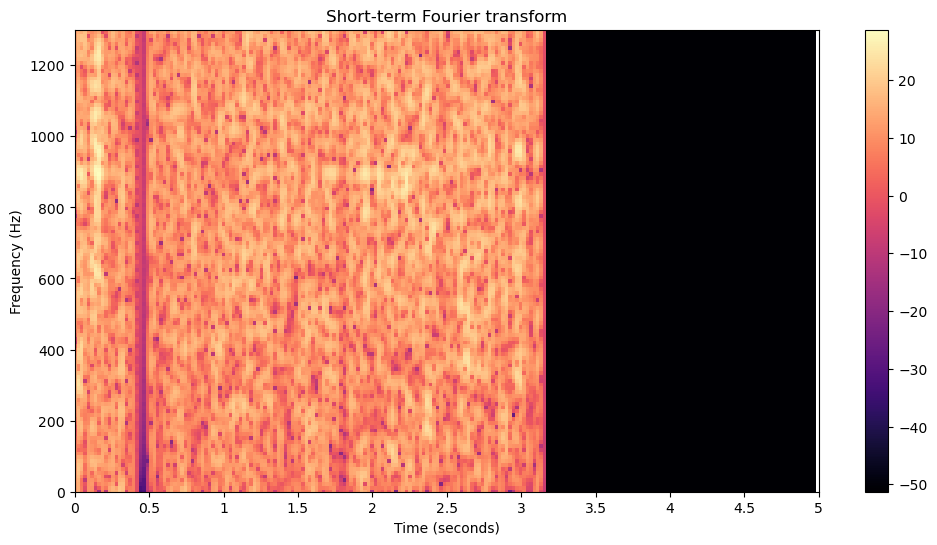

In [97]:
# Affichage du spectrogramme

plt.figure(figsize=(12, 6))

y_stft = librosa.stft(np.array(audio), win_length=1024)
y_spectrogram = librosa.amplitude_to_db(np.abs(y_stft))
specshow(y_spectrogram, cmap="magma", x_axis="time", y_axis="hz")
plt.title("Short-term Fourier transform")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.xlim(0, duration)
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 1300);